This is the ExuFlex software tool developed by the 2023 iGEM Vilnius-Lithuania team. The usage instructions are available below. To learn more about this software tool and the Exullose linker software suite in general visit our wiki: https://2023.igem.wiki/vilnius-lithuania/software

In [ ]:
# @title Run this cell first
import ipywidgets as widgets
from IPython.display import display
import numpy as np

# Function to parse FASTA file
def parse_fasta(contents):
    lines = contents.split("\n")
    job_name = lines[0][1:]  # Remove the ">" character
    sequence = "".join(lines[1:])
    return job_name, sequence

# Callback function for file upload
def on_file_upload(change):
    uploaded_file = list(file_upload.value.values())[0]
    contents = uploaded_file['content'].decode('utf-8')
    job_name, sequence = parse_fasta(contents)
    sequence_of_interest.value = sequence
    name_of_the_job.value = job_name

# File upload widget
file_upload = widgets.FileUpload(
    accept='.faa',  # Accept only .fasta files
    multiple=False,  # Allow only single file upload
    description="Upload .faa file"
)
file_upload.observe(on_file_upload, names='value')
display(file_upload)
# A widget for inputting the sequence to run dfi on
sequence_of_interest_label = widgets.Label(value='Enter the amino acid sequence of interest:')
sequence_of_interest = widgets.Textarea(
    value='',
    placeholder='Enter amino acid sequence',
    rows=1,
    layout=widgets.Layout(width="auto")
)
sequence_of_interest_container = widgets.HBox([sequence_of_interest_label, sequence_of_interest])
display(sequence_of_interest_container)
# Another widget for inputing the job name
name_of_the_job_label = widgets.Label(value='Enter a name for this job:')
name_of_the_job = widgets.Textarea(
    value='',
    placeholder='jobname',
    rows=1,
    layout=widgets.Layout(width="auto")
)
name_of_the_job_container = widgets.HBox([name_of_the_job_label, name_of_the_job])
display(name_of_the_job_container)


# Widget for the unfinished feature for relaxation with AMBER
structure_relaxation_question_label = widgets.Label(value='Do you want the structure to be relaxed with AMBER?:')
structure_relaxation_question = widgets.Checkbox(
    value=False,
    description='',
    disabled=False,
    indent=False
)
structure_relaxation_question_container = widgets.HBox([structure_relaxation_question_label, structure_relaxation_question])
# A wdiget for the remove feature that outputs the percentile dfi and on the "absolute" dfi value
pctdfi_or_dfi_label = widgets.Label(value='Do you want the %DFI or DFI metric?(check for %DFI):')
pctdfi_or_dfi = widgets.Checkbox(
    value=False,
    description='',
    disabled=False,
    indent=False
)
pctdfi_or_dfi_container = widgets.HBox([pctdfi_or_dfi_label, pctdfi_or_dfi])

In [ ]:
# @title After inputing the sequence and the jobname or uploading a .faa file, run this cell for the prediction

  # The following code is the colabfold portion of our software, the majority of this code was taken from the colabfold notebook and adapted into functions, so we could call them without runnining seperate cells.
def cf_collect_user_input (cf_sequence, cf_jobname, cf_num_relax=0, cf_template_mode='none'):
  global files, os, re, hashlib, random
  from google.colab import files
  import os
  import re
  import hashlib
  import random

  from sys import version_info
  python_version = f"{version_info.major}.{version_info.minor}"


  def add_hash(x,y):
    return x+"_"+hashlib.sha1(y.encode()).hexdigest()[:5]

  query_sequence = cf_sequence
  #  - Use `:` to specify inter-protein chainbreaks for **modeling complexes** (supports homo- and hetro-oligomers). For example **PI...SK:PI...SK** for a homodimer
  jobname = cf_jobname
  # number of models to use
  num_relax = cf_num_relax # [0, 1, 5] {type:"raw"}
  # - specify how many of the top ranked structures to relax using amber
  template_mode = cf_template_mode # ["none", "pdb100","custom"]
  # - `none` = no template information is used. `pdb100` = detect templates in pdb100 (see [notes](#pdb100)). `custom` - upload and search own templates (PDB or mmCIF format, see [notes](#custom_templates))

  use_amber = num_relax > 0

  # remove whitespaces
  query_sequence = "".join(query_sequence.split())

  basejobname = "".join(jobname.split())
  basejobname = re.sub(r'\W+', '', basejobname)
  jobname = add_hash(basejobname, query_sequence)

  # check if directory with jobname exists
  def check(folder):
    if os.path.exists(folder):
      return False
    else:
      return True
  if not check(jobname):
    n = 0
    while not check(f"{jobname}_{n}"): n += 1
    jobname = f"{jobname}_{n}"

  # make directory to save results
  os.makedirs(jobname, exist_ok=True)

  # save queries
  queries_path = os.path.join(jobname, f"{jobname}.csv")
  with open(queries_path, "w") as text_file:
    text_file.write(f"id,sequence\n{jobname},{query_sequence}")

  if template_mode == "pdb100":
    use_templates = True
    custom_template_path = None
  elif template_mode == "custom":
    custom_template_path = os.path.join(jobname,f"template")
    os.makedirs(custom_template_path, exist_ok=True)
    uploaded = files.upload()
    use_templates = True
    for fn in uploaded.keys():
      os.rename(fn,os.path.join(custom_template_path,fn))
  else:
    custom_template_path = None
    use_templates = False

  print("jobname",jobname)
  print("sequence",query_sequence)
  print("length",len(query_sequence.replace(":","")))
  return query_sequence, jobname, num_relax, template_mode, use_amber, custom_template_path, use_templates, python_version, queries_path

def install_colabfold_dependencies(use_amber, use_templates, python_version):
  # Install dependencies
  import os
  USE_AMBER = use_amber
  USE_TEMPLATES = use_templates
  PYTHON_VERSION = python_version

  if not os.path.isfile("COLABFOLD_READY"):
    print("installing colabfold...")
    os.system("pip install -q --no-warn-conflicts 'colabfold[alphafold-minus-jax] @ git+https://github.com/sokrypton/ColabFold'")
    os.system("pip install --upgrade dm-haiku")
    os.system("ln -s /usr/local/lib/python3.*/dist-packages/colabfold colabfold")
    os.system("ln -s /usr/local/lib/python3.*/dist-packages/alphafold alphafold")
    # patch for jax > 0.3.25
    os.system("sed -i 's/weights = jax.nn.softmax(logits)/logits=jnp.clip(logits,-1e8,1e8);weights=jax.nn.softmax(logits)/g' alphafold/model/modules.py")
    os.system("touch COLABFOLD_READY")

  if USE_AMBER or USE_TEMPLATES:
    if not os.path.isfile("CONDA_READY"):
      print("installing conda...")
      os.system("wget -qnc https://github.com/conda-forge/miniforge/releases/latest/download/Mambaforge-Linux-x86_64.sh")
      os.system("bash Mambaforge-Linux-x86_64.sh -bfp /usr/local")
      os.system("mamba config --set auto_update_conda false")
      os.system("touch CONDA_READY")

  if USE_TEMPLATES and not os.path.isfile("HH_READY") and USE_AMBER and not os.path.isfile("AMBER_READY"):
    print("installing hhsuite and amber...")
    os.system(f"mamba install -y -c conda-forge -c bioconda kalign2=2.04 hhsuite=3.3.0 openmm=7.7.0 python='{PYTHON_VERSION}' pdbfixer")
    os.system("touch HH_READY")
    os.system("touch AMBER_READY")
  else:
    if USE_TEMPLATES and not os.path.isfile("HH_READY"):
      print("installing hhsuite...")
      os.system(f"mamba install -y -c conda-forge -c bioconda kalign2=2.04 hhsuite=3.3.0 python='{PYTHON_VERSION}'")
      os.system("touch HH_READY")
    if USE_AMBER and not os.path.isfile("AMBER_READY"):
      print("installing amber...")
      os.system(f"mamba install -y -c conda-forge openmm=7.7.0 python='{PYTHON_VERSION}' pdbfixer")
      os.system("touch AMBER_READY")


def cf_configure_msa (jobname, query_sequence, msa_mode='mmseqs2_uniref_env', pair_mode='unpaired_paired'):
  # MSA options (custom MSA upload, single sequence, pairing mode)
  msa_mode = msa_mode # ["mmseqs2_uniref_env", "mmseqs2_uniref","single_sequence","custom"]
  pair_mode = pair_mode # ["unpaired_paired","paired","unpaired"] {type:"string"}
  # - "unpaired_paired" = pair sequences from same species + unpaired MSA, "unpaired" = seperate MSA for each chain, "paired" - only use paired sequences.

  # decide which a3m to use
  if "mmseqs2" in msa_mode:
    a3m_file = os.path.join(jobname,f"{jobname}.a3m")

  elif msa_mode == "custom":
    a3m_file = os.path.join(jobname,f"{jobname}.custom.a3m")
    if not os.path.isfile(a3m_file):
      custom_msa_dict = files.upload()
      custom_msa = list(custom_msa_dict.keys())[0]
      header = 0
      import fileinput
      for line in fileinput.FileInput(custom_msa,inplace=1):
        if line.startswith(">"):
          header = header + 1
        if not line.rstrip():
          continue
        if line.startswith(">") == False and header == 1:
          query_sequence = line.rstrip()
        print(line, end='')

      os.rename(custom_msa, a3m_file)
      queries_path=a3m_file
      print(f"moving {custom_msa} to {a3m_file}")

  else:
    a3m_file = os.path.join(jobname,f"{jobname}.single_sequence.a3m")
    with open(a3m_file, "w") as text_file:
      text_file.write(">1\n%s" % query_sequence)
  print(msa_mode, pair_mode)
  return msa_mode, pair_mode


def cf_advanced_settings(
    model_type="auto",
    num_recycles="auto",
    recycle_early_stop_tolerance="auto",
    pairing_strategy="greedy",
    max_msa="auto",
    num_seeds=1,
    use_dropout=False,
    save_all=False,
    save_recycles=False,
    save_to_google_drive=False,
    dpi=200
):
  # ### Advanced settings
  model_type = model_type #@ ["auto", "alphafold2_ptm", "alphafold2_multimer_v1", "alphafold2_multimer_v2", "alphafold2_multimer_v3"]
  # - if `auto` selected, will use `alphafold2_ptm` for monomer prediction and `alphafold2_multimer_v3` for complex prediction.
  # Any of the mode_types can be used (regardless if input is monomer or complex).
  num_recycles = num_recycles #@ ["auto", "0", "1", "3", "6", "12", "24", "48"]
  recycle_early_stop_tolerance = recycle_early_stop_tolerance #@ ["auto", "0.0", "0.5", "1.0"]
  # - if `auto` selected, will use 20 recycles if `model_type=alphafold2_multimer_v3` (with tol=0.5), all else 3 recycles (with tol=0.0).
  pairing_strategy = pairing_strategy # ["greedy", "complete"] {type:"string"}
  # - `greedy` = pair any taxonomically matching subsets, `complete` = all sequences have to match in one line.


  # #### Sample settings
  # -  enable dropouts and increase number of seeds to sample predictions from uncertainty of the model.
  # -  decrease `max_msa` to increase uncertainity
  max_msa = max_msa #@ ["auto", "512:1024", "256:512", "64:128", "32:64", "16:32"]
  num_seeds = num_seeds #@ [1,2,4,8,16] {type:"raw"}
  use_dropout = use_dropout #@ {type:"boolean"}

  num_recycles = None if num_recycles == "auto" else int(num_recycles)
  recycle_early_stop_tolerance = None if recycle_early_stop_tolerance == "auto" else float(recycle_early_stop_tolerance)
  if max_msa == "auto": max_msa = None

  # #### Save settings
  save_all = save_all #@ {type:"boolean"}
  save_recycles = save_recycles #@ {type:"boolean"}
  save_to_google_drive = save_to_google_drive #@ {type:"boolean"}
  # -  if the save_to_google_drive option was selected, the result zip will be uploaded to your Google Drive
  dpi = 200 #@ {type:"integer"}
  # - set dpi for image resolution

  if save_to_google_drive:
    from pydrive.drive import GoogleDrive
    from pydrive.auth import GoogleAuth
    from google.colab import auth
    from oauth2client.client import GoogleCredentials
    auth.authenticate_user()
    gauth = GoogleAuth()
    gauth.credentials = GoogleCredentials.get_application_default()
    drive = GoogleDrive(gauth)
    print("You are logged into Google Drive and are good to go!")
  print(model_type, num_recycles, recycle_early_stop_tolerance, pairing_strategy, max_msa, num_seeds, use_dropout, save_all, save_recycles, save_to_google_drive, dpi)
  return (
        model_type,
        num_recycles,
        recycle_early_stop_tolerance,
        pairing_strategy,
        max_msa,
        num_seeds,
        use_dropout,
        save_all,
        save_recycles,
        save_to_google_drive,
        dpi
    )
def cf_run_prediction(
    jobname,
    msa_mode,
    model_type,
    num_recycles,
    recycle_early_stop_tolerance,
    pairing_strategy,
    max_msa,
    num_seeds,
    use_dropout,
    save_all,
    save_recycles,
    use_amber,
    queries_path,
    use_templates,
    custom_template_path,
    num_relax,
    pair_mode,
    dpi,
    display_images = False,
):
  display_images = display_images # {type:"boolean"}

  import sys
  import warnings
  warnings.simplefilter(action='ignore', category=FutureWarning)
  from Bio import BiopythonDeprecationWarning
  warnings.simplefilter(action='ignore', category=BiopythonDeprecationWarning)
  from pathlib import Path
  from colabfold.download import download_alphafold_params, default_data_dir
  from colabfold.utils import setup_logging
  from colabfold.batch import get_queries, run, set_model_type
  from colabfold.plot import plot_msa_v2

  import os
  import numpy as np
  try:
    K80_chk = os.popen('nvidia-smi | grep "Tesla K80" | wc -l').read()
  except:
    K80_chk = "0"
    pass
  if "1" in K80_chk:
    print("WARNING: found GPU Tesla K80: limited to total length < 1000")
    if "TF_FORCE_UNIFIED_MEMORY" in os.environ:
      del os.environ["TF_FORCE_UNIFIED_MEMORY"]
    if "XLA_PYTHON_CLIENT_MEM_FRACTION" in os.environ:
      del os.environ["XLA_PYTHON_CLIENT_MEM_FRACTION"]

  from colabfold.colabfold import plot_protein
  from pathlib import Path
  import matplotlib.pyplot as plt

  # For some reason we need that to get pdbfixer to import
  if use_amber and f"/usr/local/lib/python{python_version}/site-packages/" not in sys.path:
      sys.path.insert(0, f"/usr/local/lib/python{python_version}/site-packages/")

  def input_features_callback(input_features):
    if display_images:
      plot_msa_v2(input_features)
      plt.show()
      plt.close()

  def prediction_callback(protein_obj, length,
                          prediction_result, input_features, mode):
    model_name, relaxed = mode
    if not relaxed:
      if display_images:
        fig = plot_protein(protein_obj, Ls=length, dpi=150)
        plt.show()
        plt.close()

  result_dir = jobname
  log_filename = os.path.join(jobname,"log.txt")
  if not os.path.isfile(log_filename) or 'logging_setup' not in globals():
    setup_logging(Path(log_filename))
    logging_setup = True

  queries, is_complex = get_queries(queries_path)
  model_type = set_model_type(is_complex, model_type)

  if "multimer" in model_type and max_msa is not None:
    use_cluster_profile = False
  else:
    use_cluster_profile = True

  download_alphafold_params(model_type, Path("."))
  results = run(
      queries=queries,
      result_dir=result_dir,
      use_templates=use_templates,
      custom_template_path=custom_template_path,
      num_relax=num_relax,
      msa_mode=msa_mode,
      model_type=model_type,
      num_models=5,
      num_recycles=num_recycles,
      recycle_early_stop_tolerance=recycle_early_stop_tolerance,
      num_seeds=num_seeds,
      use_dropout=use_dropout,
      model_order=[1,2,3,4,5],
      is_complex=is_complex,
      data_dir=Path("."),
      keep_existing_results=False,
      rank_by="auto",
      pair_mode=pair_mode,
      pairing_strategy=pairing_strategy,
      stop_at_score=float(100),
      prediction_callback=prediction_callback,
      dpi=dpi,
      zip_results=False,
      save_all=save_all,
      max_msa=max_msa,
      use_cluster_profile=use_cluster_profile,
      input_features_callback=input_features_callback,
      save_recycles=save_recycles,
  )
  results_zip = f"{jobname}.result.zip"
  os.system(f"zip -r {results_zip} {jobname}")
  return results_zip, results

def cf_master_predict(cf_sequence='PIAQIHILEGRSDEQKETLIREVSEAISRSLDAPLTSVRVIITEMAKGHFGIGGELASK', cf_jobname='test', cf_num_relax=0, cf_template_mode='none'):
  #combo
  query_sequence, jobname, num_relax, template_mode, use_amber, custom_template_path, use_templates, python_version, queries_path = cf_collect_user_input(cf_sequence, cf_jobname, cf_num_relax, cf_template_mode)
  install_colabfold_dependencies(use_amber, use_templates, python_version)
  msa_mode, pair_mode = cf_configure_msa(jobname, query_sequence)
  model_type, num_recycles, recycle_early_stop_tolerance, pairing_strategy, max_msa, num_seeds, use_dropout, save_all, save_recycles, save_to_google_drive, dpi = cf_advanced_settings()
  results_zip, results = cf_run_prediction(jobname, msa_mode, model_type, num_recycles, recycle_early_stop_tolerance, pairing_strategy, max_msa, num_seeds, use_dropout, save_all, save_recycles, use_amber, queries_path, use_templates, custom_template_path, num_relax, pair_mode, dpi)
  return results_zip, results, jobname, msa_mode, model_type, num_recycles, recycle_early_stop_tolerance, pairing_strategy, max_msa, num_seeds, use_dropout, save_all, save_recycles, use_amber, queries_path, use_templates, custom_template_path, num_relax, pair_mode, dpi
#This is the end of the colabfold portion

#The if statement is an unfinished feature for relaxation with amber
if structure_relaxation_question.value:
  how_many_top_structures = 1
else:
  how_many_top_structures = 0
print (how_many_top_structures)

#COLLABFOLD PREDICTIONS
results_zip, results, jobname, msa_mode, model_type, num_recycles, recycle_early_stop_tolerance, pairing_strategy, max_msa, num_seeds, use_dropout, save_all, save_recycles, use_amber, queries_path, use_templates, custom_template_path, num_relax, pair_mode, dpi = cf_master_predict(str(sequence_of_interest.value), str(name_of_the_job.value), how_many_top_structures)
print (jobname)

#DFI PREP
!pip install git+http://github.com/avishekrk/dfi.git
#the dfi repo says that the pip install requirements is necessary but it works without, so we just commented it out:
#!pip install numpy backports.shutil-get-terminal-size biopython cycler decorator enum34 matplotlib pandas pathlib2 pexpect pickleshare prompt-toolkit ptyprocess py Pygments pyparsing python-dateutil pytz requests scipy seaborn simplegeneric six traitlets wcwidth argparse

%pylab inline
import pandas as pd
import seaborn as sns
import dfi.dfi_calc
import os

print(os.getcwd())
os.makedirs('dfi_results', exist_ok=True) # create the folder in which the dfi results will be saved
os.makedirs('filtered_dfi_results', exist_ok=True) # create the folder in which the dfi results will be saved

import os

def construct_path_to_results_for_dfi(generated_jobname, amber_relaxations_num):
    possible_model_numbers = [1, 2, 3, 4, 5]

    for model_number in possible_model_numbers:
        filename = f'/content/{generated_jobname}/{generated_jobname}_relaxed_rank_001_alphafold2_ptm_model_{model_number}_seed_000.pdb' if amber_relaxations_num == 1 else f'/content/{generated_jobname}/{generated_jobname}_unrelaxed_rank_001_alphafold2_ptm_model_{model_number}_seed_000.pdb'

        if os.path.exists(filename):
            print(f'Found file with model number {model_number}: {filename}')
            return filename

    print(f'No matching file found for model numbers {possible_model_numbers}')
    return None

def dfi_calculate_flexibility(pdb_for_dfi, generated_jobname):
  output_folder = '/content/dfi_results/'
  csv_filename = f'{generated_jobname}_dfi_results.csv'  # Construct the filename

  def save_dataframe_to_csv(df, filename, folder = 'df'):
      file_path = os.path.join(folder, filename)
      df.to_csv(file_path, index=False)       # Save the DataFrame to the specified CSV file

  df_dfi = dfi.calc_dfi(pdb_for_dfi) #CALCULATE THE DFI RESULTS INTO A DATAFRAME
  save_dataframe_to_csv(df_dfi, csv_filename, output_folder)   # Save the DataFrame to the specified folder and filename
  saved_file_path_dfi = os.path.join(output_folder, csv_filename)      # Create a filepath to the saved results for further proccesing
  return saved_file_path_dfi

def linker_dfi(saved_file_path_dfi, generated_jobname, start_index = 4, end_index = 8):
  import csv
  output_folder = '/content/filtered_dfi_results/'
  custom_filename = f'{generated_jobname}_filtered_dfi_results.csv'
  output_file_path = os.path.join(output_folder, custom_filename)
  # Open the input CSV file for reading
  with open(saved_file_path_dfi, mode='r') as input_file:
      reader = csv.reader(input_file)
      header = next(reader)  # Read and save the header row

      # Read all rows into a list
      all_rows = list(reader)

  # Filter the rows based on the desired index range
  filtered_rows = all_rows[start_index - 1 : end_index]  # Subtract 1 to account for 0-based indexing

  # Open the output CSV file for writing
  with open(output_file_path, mode='w', newline='') as output_file:
      writer = csv.writer(output_file)

      # Write the header row
      writer.writerow(header)

      # Write the filtered rows
      writer.writerows(filtered_rows)
  return output_file_path


def dfi_plot (csv_file):
  df_dfi = pd.read_csv(csv_file)
  sns.set_style("whitegrid")
  plt.figure(figsize=(32, 12))
  sns.set_context("poster", font_scale=2.25, rc={"lines.linewidth": 1.25,"lines.markersize":8})

  ResI = df_dfi.ResI.values
  if pctdfi_or_dfi.value == True:
    pctdfi = df_dfi.pctdfi.values
  else:
    pctdfi = df_dfi.dfi.values

  plt.plot(ResI, pctdfi, label='DFI plot',
          marker='o', linestyle='--', markersize=20)
  plt.xlabel('Residue')

  if pctdfi_or_dfi.value == True:
    plt.ylabel('%DFI')
  else:
    plt.ylabel('DFI')

  plt.legend(bbox_to_anchor=(0., 1.005, 1., .102), loc=7,ncol=2, borderaxespad=0.)
#DFI PREP

dfi_plot(dfi_calculate_flexibility(construct_path_to_results_for_dfi(jobname, how_many_top_structures), jobname))


Acknowledgements:

This tool uses code from Colabfold, AlphaFold2 and the DFI package.

Colabfold github: https://github.com/sokrypton/ColabFold

Mirdita M, Schütze K, Moriwaki Y, Heo L, Ovchinnikov S and Steinegger M. ColabFold: Making protein folding accessible to all.
Nature Methods (2022) doi: 10.1038/s41592-022-01488-1

Jumper et al. "Highly accurate protein structure prediction with AlphaFold."
Nature (2021) doi: 10.1038/s41586-021-03819-2

DFI github: https://github.com/avishekrk/DFI

Gerek, Z. N., Kumar, S., & Ozkan, S. B. (2013). Structural dynamics flexibility informs function and evolution at a proteome scale. Evolutionary Applications, 6(3), 423–433. https://doi.org/10.1111/eva.12052

Instructions:
1. Make sure you are signed in to your Google account.
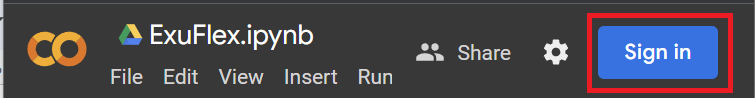
2. Run the first code cell by clicking on the run cell button.
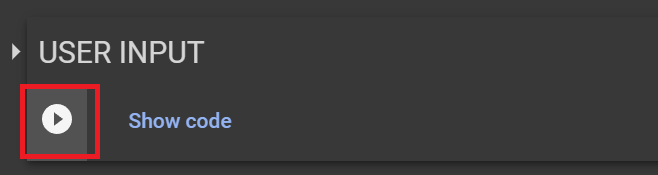
3. Wait for the notebook to connect to a Google Colab notebook.
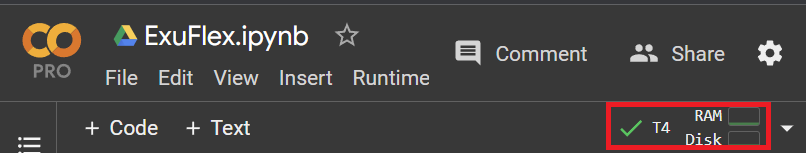
4. Input the sequence of interest and a jobname into the input fields or alternatively provide an amino acid FASTA file (.faa).
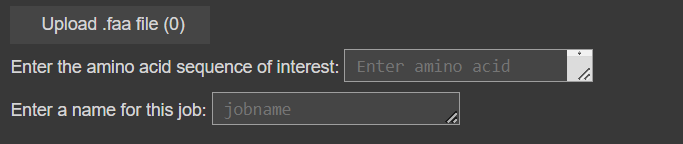
5. Run the next code cell by clicking on the run cell button.

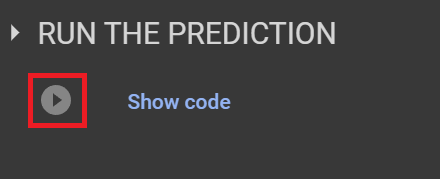
6. Wait for the program to run and draw a flexibility graph, which will appear at the bottom of the code cell output.
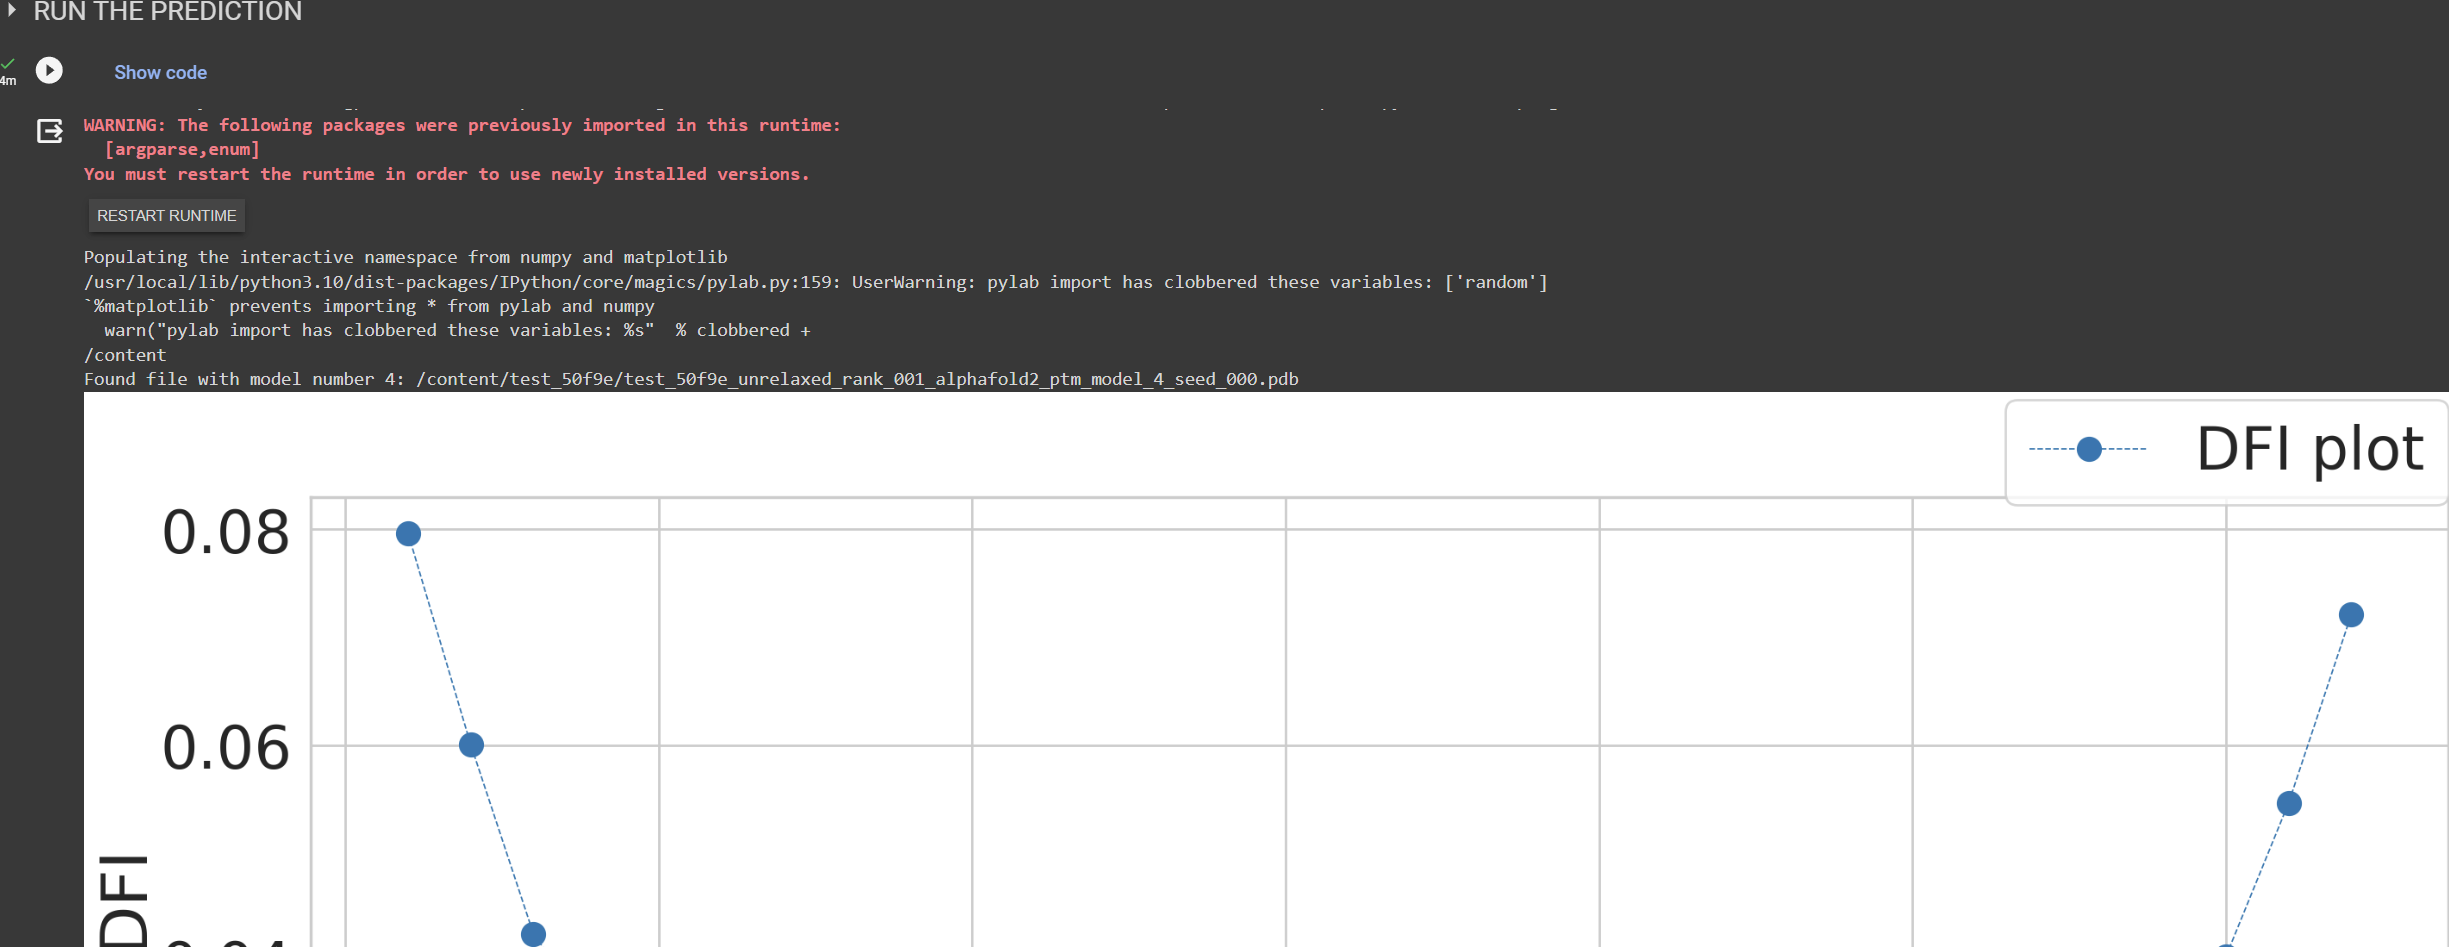